In [1]:
from models.product import Product
from models.machine import Machine
from models.worker import Worker
from models.factory import Factory

In [2]:
from models.status import Mstatus
from models.status import Wstatus

In [3]:
from utils.utils import make_dic_points_from_route
from utils.utils import points_to_move_list
from utils.utils import points_to_sec
from utils.utils import route_to_move_list
from utils.utils import shortest_path
from utils.utils import sec_to_timedelta_8h
from utils.utils import sec_to_timedelta_9h
from utils.utils import return_biz_day

In [4]:
from views.application import Application
from views.layout import Layout
from views.productSchedule import ProductSchedule
#from views import worker_graph
#from views import machine_graph
#from views import heatmap

In [5]:
import time
import datetime
import pandas as pd
import functools
#import threading
import tkinter as tk
from tkinter import ttk
import time
import networkx as nx
import numpy as np
import copy
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
#from numba import jit

In [6]:
#from data.map import MAZE
from data.map import WALL
from data.position import POSITIONS
from data.position import PATH
from data.map import MACHINE_POSITION

In [7]:
from algorithm.algorithm import continue_set_up

In [8]:
BASE_DATE = datetime.datetime(2021, 1, 25)

In [9]:
import logging

# コンソールに表示するのはINFOレベル以上。
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

#ファイルに出力するのは DEBUG レベル以上。
file_handler = logging.FileHandler('log.log', mode='w', encoding='utf-8')
file_handler.setLevel(logging.DEBUG)

formatter1 = '%(filename)s : %(lineno)s : %(funcName)s : %(levelname)s : %(message)s'
formatter2 = '%(funcName)s : %(levelname)s : %(message)s'

logging.basicConfig(
    level=logging.ERROR,
    handlers=[stream_handler, file_handler],
    format=formatter2
)


In [10]:
products = [
    ('P1', 20, 'NL', 10, 5, 1, 'H3', 10, 1, 1, 'S1', 2, 1, 1), 
    ('P2', 30, 'NL', 10, 5, 1, 'B1', 5, 1, 1, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'H6', 10, 1, 1, 'S2', 2, 1, 1), 
    ('P3', 20, 'CL', 15, 5, 1, 'D8', 15, 1, 1, 'S2', 1, 1, 1, 'Z2', 1, 1, 1), 
    ('P4', 15, 'SW1', 3, 1, 1, 'L2', 10, 1, 1, 'H2', 5, 1, 1), 
    ('P5', 15, 'D9', 10, 1, 1, 'S2', 1, 1, 1, 'Z2', 1, 1, 1), 
    ('P6', 15, 'SF', 5, 1, 1, 'L2', 1, 1, 1, 'Z3', 1, 1, 1), 
    ('P7', 15, 'B1', 5, 1, 1, 'H1', 20, 1, 2, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'S1', 2, 1, 1, 'Z2', 1, 1, 1), 
    ('P8', 30, 'NL', 10, 5, 1, 'H3', 10, 1, 1, 'S1', 2, 1, 1), 
    ('P9', 30, 'H3', 15, 1, 1, 'S2', 1, 1, 1), 
    ('P10', 30, 'NL', 15, 5, 1, 'B1', 5, 1, 1, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'H6', 20, 1, 2, 'S2', 1, 1, 1)]
pr = pd.DataFrame(products, columns=(
    'product', 'lot', 
    'process-1', 'time-1', 'auto-1', 'repeat-1', 
    'process-2', 'time-2', 'auto-2', 'repeat-2', 
    'process-3', 'time-3', 'auto-3', 'repeat-3',
    'process-4', 'time-4', 'auto-4', 'repeat-4', 
    'process-5', 'time-5', 'auto-5', 'repeat-5',
    'process-6', 'time-6', 'auto-6', 'repeat-6'))
pr

,product,lot,process-1,time-1,auto-1,repeat-1,process-2,time-2,auto-2,repeat-2,...,auto-4,repeat-4,process-5,time-5,auto-5,repeat-5,process-6,time-6,auto-6,repeat-6
0,P1,20,NL,10,5,1,H3,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
1,P2,30,NL,10,5,1,B1,5,1,1,...,1.0,1.0,H6,10.0,1.0,1.0,S2,2.0,1.0,1.0
2,P3,20,CL,15,5,1,D8,15,1,1,...,1.0,1.0,None,NaN,NaN,NaN,None,NaN,NaN,NaN
3,P4,15,SW1,3,1,1,L2,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
4,P5,15,D9,10,1,1,S2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
5,P6,15,SF,5,1,1,L2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
6,P7,15,B1,5,1,1,H1,20,1,2,...,1.0,1.0,S1,2.0,1.0,1.0,Z2,1.0,1.0,1.0
7,P8,30,NL,10,5,1,H3,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
8,P9,30,H3,15,1,1,S2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
9,P10,30,NL,15,5,1,B1,5,1,1,...,1.0,1.0,H6,20.0,1.0,2.0,S2,1.0,1.0,1.0


In [11]:
workers = [('Taro', 30, 'M', 1.2, 2.0, '8:00', '17:00', '1'), 
           ('Hanako', 40, 'F', 1.0, 1.0, '8:30', '16:30', '1'),
           ('Ichiro', 20, 'F', 1.0, 0.8, '8:00', '12:00', '8')]
wk = pd.DataFrame(workers, columns=('name', 'age', 'sex', 'm_speed', 'w_speed', 'arrive', 'leave', 'position'))
wk

,name,age,sex,m_speed,w_speed,arrive,leave,position
0,Taro,30,M,1.2,2.0,8:00,17:00,1
1,Hanako,40,F,1.0,1.0,8:30,16:30,1
2,Ichiro,20,F,1.0,0.8,8:00,12:00,8


In [12]:
sample_workers = [('Taro', 30, 'M', 1.2, 2.0, '8:00', '17:00', '1'), 
                  ('Hanako', 40, 'F', 1.0, 1.0, '8:30', '16:30', '1'),
                  ('Ichiro', 20, 'F', 1.0, 0.8, '8:00', '12:00', '8'),
                  ('Saburo', 30, 'M', 1.0, 1.0, '8:00', '17:00', '8'),
                  ('Makoto', 30, 'M', 1.0, 1.0, '8:00', '17:00', '8')]
sw = pd.DataFrame(sample_workers, columns=('name', 'age', 'sex', 'm_speed', 'w_speed', 'arrive', 'leave', 'position'))
sw

,name,age,sex,m_speed,w_speed,arrive,leave,position
0,Taro,30,M,1.2,2.0,8:00,17:00,1
1,Hanako,40,F,1.0,1.0,8:30,16:30,1
2,Ichiro,20,F,1.0,0.8,8:00,12:00,8
3,Saburo,30,M,1.0,1.0,8:00,17:00,8
4,Makoto,30,M,1.0,1.0,8:00,17:00,8


In [13]:
Taro_schedule = [
    ('Meeting', 'Mon', 'MeetingRoom', '8', '10:00', '10:15'),
    ('Deskwork', 'Mon', 'Office', '1', '11:00', '12:00'), 
    ('Lunch', 'Mon', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Mon', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Mon', 'Office', '1', '16:00', '17:00'),
    ('Deskwork', 'Tue', 'Office', '1', '11:00', '12:00'), 
    ('Lunch', 'Tue', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Tue', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Tue', 'Office', '1', '16:00', '17:00'),
    ('Deskwork', 'wed', 'Office', '1', '11:00', '12:00'), 
    ('Lunch', 'Wed', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Wed', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Wed', 'MeetingRoom', '1', '16:00', '17:00'),
    ('Deskwork', 'Thu', 'Office', '1', '11:00', '12:00'), 
    ('Lunch', 'Thu', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Thu', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Thu', 'MeetingRoom', '1', '16:00', '17:00'),
    ('Deskwork', 'Fri', 'Office', '1', '11:00', '12:00'), 
    ('Lunch', 'Fri', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Fri', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Fri', 'Office', '1', '16:00', '17:00')
]
ts = pd.DataFrame(Taro_schedule, columns=('task', 'week', 'place', 'position', 'start', 'end'))
ts

,task,week,place,position,start,end
0,Meeting,Mon,MeetingRoom,8,10:00,10:15
1,Deskwork,Mon,Office,1,11:00,12:00
2,Lunch,Mon,MeetingRoom,8,12:00,12:45
3,Break,Mon,MeetingRoom,8,15:00,15:15
4,Deskwork,Mon,Office,1,16:00,17:00
5,Deskwork,Tue,Office,1,11:00,12:00
6,Lunch,Tue,MeetingRoom,8,12:00,12:45
7,Break,Tue,MeetingRoom,8,15:00,15:15
8,Deskwork,Tue,Office,1,16:00,17:00
9,Deskwork,wed,Office,1,11:00,12:00


In [14]:
Hanako_schedule = [
    ('Lapping', 'Mon', 'MeetingRoom', '8', '8:30', '10:00'),
    ('Meeting', 'Mon', 'MeetingRoom', '8', '10:00', '10:15'),
    ('Lapping', 'Mon', 'MeetingRoom', '8', '10:15', '12:00'),
    ('Lunch', 'Mon', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Mon', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Mon', 'Office', '1', '16:00', '16:30'),
    ('Lapping', 'Tue', 'MeetingRoom', '8', '8:30', '12:00'), 
    ('Lunch', 'Tue', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Tue', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Tue', 'Office', '1', '16:00', '16:30'),
    ('Lapping', 'Wed', 'MeetingRoom', '8', '8:30', '12:00'), 
    ('Lunch', 'Wed', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Wed', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Wed', 'MeetingRoom', '1', '16:00', '16:30'),
    ('Lapping', 'Thu', 'MeetingRoom', '8', '8:30', '12:00'), 
    ('Lunch', 'Thu', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Thu', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Thu', 'MeetingRoom', '1', '16:00', '16:30'),
    ('Lapping', 'Fri', 'MeetingRoom', '8', '8:30', '12:00'), 
    ('Lunch', 'Fri', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Fri', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Deskwork', 'Fri', 'Office', '1', '16:00', '16:30')
]
hs = pd.DataFrame(Hanako_schedule, columns=('task', 'week', 'place', 'position', 'start', 'end'))
hs

,task,week,place,position,start,end
0,Lapping,Mon,MeetingRoom,8,8:30,10:00
1,Meeting,Mon,MeetingRoom,8,10:00,10:15
2,Lapping,Mon,MeetingRoom,8,10:15,12:00
3,Lunch,Mon,MeetingRoom,8,12:00,12:45
4,Break,Mon,MeetingRoom,8,15:00,15:15
5,Deskwork,Mon,Office,1,16:00,16:30
6,Lapping,Tue,MeetingRoom,8,8:30,12:00
7,Lunch,Tue,MeetingRoom,8,12:00,12:45
8,Break,Tue,MeetingRoom,8,15:00,15:15
9,Deskwork,Tue,Office,1,16:00,16:30


In [15]:
Ichiro_schedule = [
    ('Meeting', 'Mon', 'MeetingRoom', '8', '10:00', '10:15')
]
i_s = pd.DataFrame(Ichiro_schedule, columns=('task', 'week', 'place', 'position', 'start', 'end'))
i_s

,task,week,place,position,start,end
0,Meeting,Mon,MeetingRoom,8,10:00,10:15


In [16]:
Sample_schedule = [
    ('Meeting', 'Mon', 'MeetingRoom', '8', '10:00', '10:15'),
    ('Lunch', 'Mon', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Mon', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Lunch', 'Tue', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Tue', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Lunch', 'Wed', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Wed', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Lunch', 'Thu', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Thu', 'MeetingRoom', '8', '15:00', '15:15'),
    ('Lunch', 'Fri', 'MeetingRoom', '8', '12:00', '12:45'),
    ('Break', 'Fri', 'MeetingRoom', '8', '15:00', '15:15'),
]
ss = pd.DataFrame(Sample_schedule, columns=('task', 'week', 'place', 'position', 'start', 'end'))
ss

,task,week,place,position,start,end
0,Meeting,Mon,MeetingRoom,8,10:00,10:15
1,Lunch,Mon,MeetingRoom,8,12:00,12:45
2,Break,Mon,MeetingRoom,8,15:00,15:15
3,Lunch,Tue,MeetingRoom,8,12:00,12:45
4,Break,Tue,MeetingRoom,8,15:00,15:15
5,Lunch,Wed,MeetingRoom,8,12:00,12:45
6,Break,Wed,MeetingRoom,8,15:00,15:15
7,Lunch,Thu,MeetingRoom,8,12:00,12:45
8,Break,Thu,MeetingRoom,8,15:00,15:15
9,Lunch,Fri,MeetingRoom,8,12:00,12:45


In [17]:
machines = [
    ('NL', '66', 'lathe', 30, 5, 0.1, 5, 0.01, 300),
    ('CL', '62', 'lathe', 20, 5, 0.2, 5, 0.02, 300),
    ('L1', '55', 'lathe', 20, 5, 0.2, 5, 0.02, 300), #汎用旋盤
    ('L2', '40', 'lathe', 20, 5, 0.2, 5, 0.02, 300), #ベンチレース
    ('B1', '34', 'milling', 5, 2, 0.1, 5, 0.01, 300), #6面加工
    ('B2', '38', 'milling', 5, 2, 0.1, 5, 0.01, 300), #バーチカル
    ('B3', '10', 'milling', 5, 2, 0.1, 5, 0.01, 300), #ボール盤
    ('HF', '17', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('D7', '47', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('H1', '46', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('SF', '45', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('H2', '44', 'milling', 40, 3, 0.2, 5, 0.02, 300), 
    ('H3', '54', 'milling', 30, 3, 0.2, 5, 0.02, 300), 
    ('H4', '34', 'milling', 30, 3, 0.2, 5, 0.02, 300), 
    ('H5', '35', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('F', '26', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('H6', '33', 'milling', 30, 3, 0.2, 5, 0.02, 300), 
    ('D8', '53', 'milling', 30, 3, 0.2, 5, 0.02, 300), 
    ('D9', '41', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A1', '32', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A2', '31', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A3', '29', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A4', '28', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A5', '52', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('A7', '29', 'milling', 30, 3, 0.2, 5, 0.02, 300),
    ('ASZ', '25', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('AS1', '36', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('AS2', '16', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('AZ1', '35', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('AZ2', '15', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('S1', '42', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('S2', '43', 'milling', 5, 2, 0.1, 5, 0.01, 300),
    ('Z1', '30', 'milling', 5, 2, 0.1, 5, 0.01, 300), #逃がし大
    ('Z2', '21', 'milling', 5, 2, 0.1, 5, 0.01, 300), #逃がし中
    ('Z3', '9', 'milling', 5, 2, 0.1, 5, 0.01, 300), #逃がし小
    ('G1', '49', 'grinder', 0.1, 0.1, 0.1, 5, 0.01, 300), #サイドカッター研磨機
    ('G2', '50', 'grinder', 0.1, 0.1, 0.1, 5, 0.01, 300), #グラインダー荒
    ('G3', '51', 'grinder', 0.1, 0.1, 0.1, 5, 0.01, 300), #グラインダー仕上げ
    ('SW1', '56', 'saw', 5, 2, 0.1, 5, 0.01, 300), #弓鋸盤
    ('SW2', '13', 'saw', 5, 2, 0.1, 5, 0.01, 300)] #弓鋸盤
ma = pd.DataFrame(machines, columns=(
    'machine', 'position', 'type', 'setup', 'setting', 
    'error_rate', 'reset', 'trouble rate', 'repair'))
ma

,machine,position,type,setup,setting,error_rate,reset,trouble rate,repair
0,NL,66,lathe,30.0,5.0,0.1,5,0.01,300
1,CL,62,lathe,20.0,5.0,0.2,5,0.02,300
2,L1,55,lathe,20.0,5.0,0.2,5,0.02,300
3,L2,40,lathe,20.0,5.0,0.2,5,0.02,300
4,B1,34,milling,5.0,2.0,0.1,5,0.01,300
5,B2,38,milling,5.0,2.0,0.1,5,0.01,300
6,B3,10,milling,5.0,2.0,0.1,5,0.01,300
7,HF,17,milling,30.0,3.0,0.2,5,0.02,300
8,D7,47,milling,30.0,3.0,0.2,5,0.02,300
9,H1,46,milling,5.0,2.0,0.1,5,0.01,300


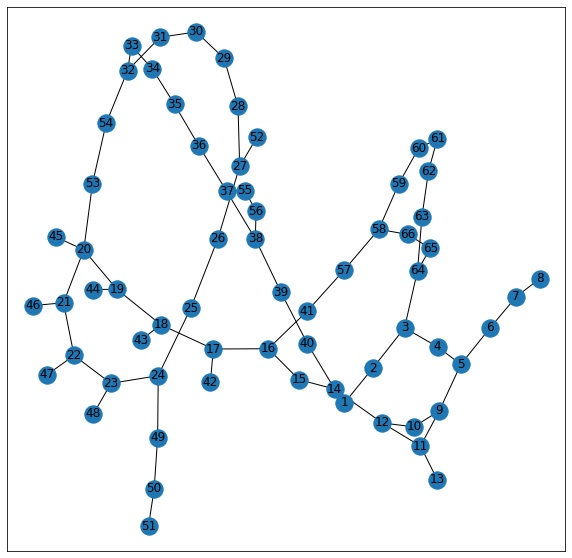

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
g = nx.Graph()
g.add_edges_from(PATH)
nx.draw_networkx(g)

In [19]:
#factory初期化
factory = Factory()

In [20]:
#作業者登録
factory.deploy(wk)
#factory.deploy(sw)

factory.set_machines(ma) #機械登録
factory.planning(pr) #生産計画登録

In [21]:
#作業者のスケジュールを登録
for worker in factory.worker_list:
    if worker.name == 'Taro':
        worker.set_schedule(ts)
    if worker.name == 'Hanako':
        worker.set_schedule(hs)
    if worker.name == 'Ichiro':
        worker.set_schedule(i_s)

In [22]:
#SampleWorkers
for worker in factory.worker_list:
    if worker.name == 'Saburo':
        worker.set_schedule(ss)
    if worker.name == 'Makoto':
        worker.set_schedule(ss)

***
## 機械を強制的に故障させる

In [23]:
h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]

for machine in factory.machine_list:
    if machine.machine_name == 'H3':
        for t in h3_trouble_schedule:
            machine.set_trouble_schedule(t[0],t[1])

***
## 担当機械登録

In [24]:
machine_list = []
for machine in factory.machine_list:
    machine_list.append(machine.machine_name)
print(machine_list)

['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'HF', 'D7', 'H1', 'SF', 'H2', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1', 'SW2']


In [25]:
machines = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'HF', 'D7', 'H1', 'SF', 'H2', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']

In [26]:
machines == machine_list

True

In [27]:
taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']

#振り分け漏れがないか確認
check_list = []
for machine in taro_charge_list:
    check_list.append(machine)
for machine in hanako_charge_list:
    check_list.append(machine)
for machine in ichiro_charge_list:
    check_list.append(machine)
set(check_list) == set(machine_list)

True

In [28]:
#担当機械登録
for worker in factory.worker_list:
    #Tato
    if worker.name == "Taro":
        worker.set_charge_list(taro_charge_list, factory.machine_list)
    #Hanako
    if worker.name == "Hanako":
        worker.set_charge_list(hanako_charge_list, factory.machine_list)
    #Ichiro
    if worker.name == "Ichiro":
        worker.set_charge_list(ichiro_charge_list, factory.machine_list)

In [29]:
#SampleWorker
for worker in factory.worker_list:
    #Saburo
    if worker.name == "Saburo":
        worker.set_charge_list(machines, factory.machine_list)
    #Makoto
    if worker.name == "Makoto":
        worker.set_charge_list(machines, factory.machine_list)

***
## 動作確認

In [30]:
#テスト用 最初の機械は段取り済み
factory.set_product_to_machine(0)
for machine in factory.machine_list:
    if machine.status == Mstatus.NOT_SET:
        machine.status = Mstatus.STOP

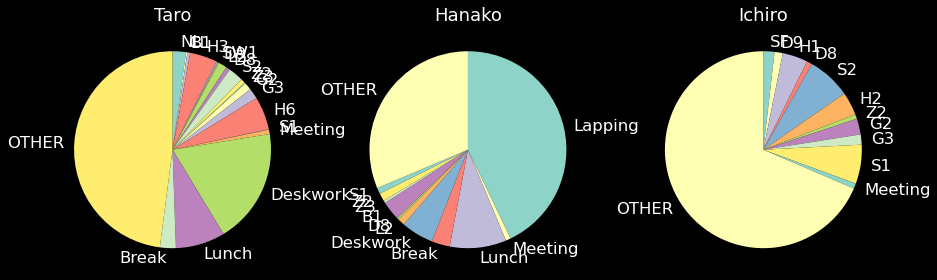

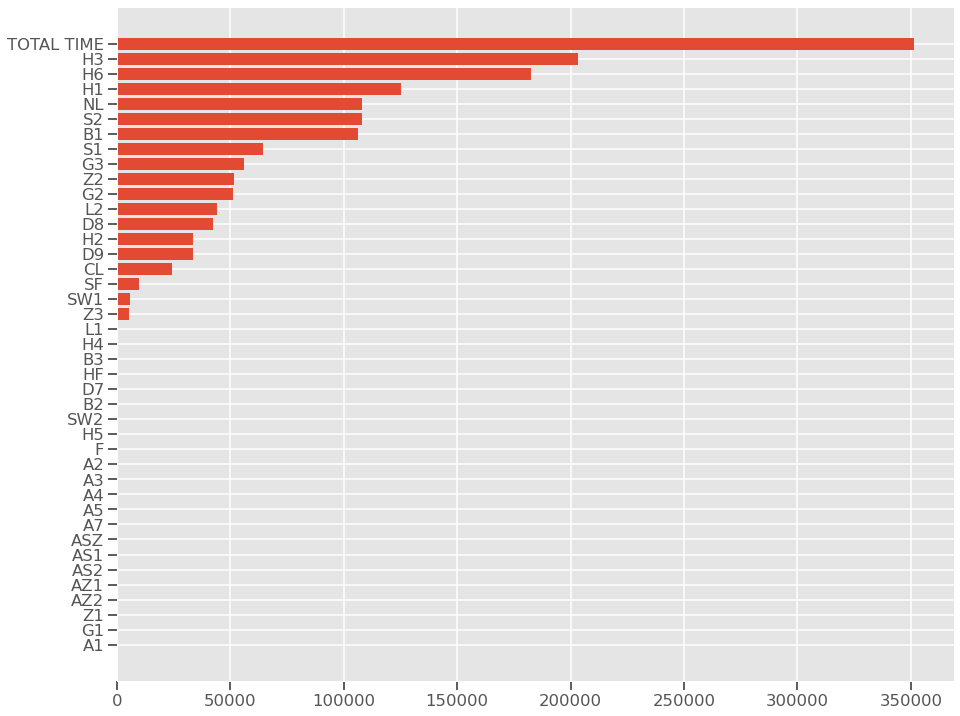

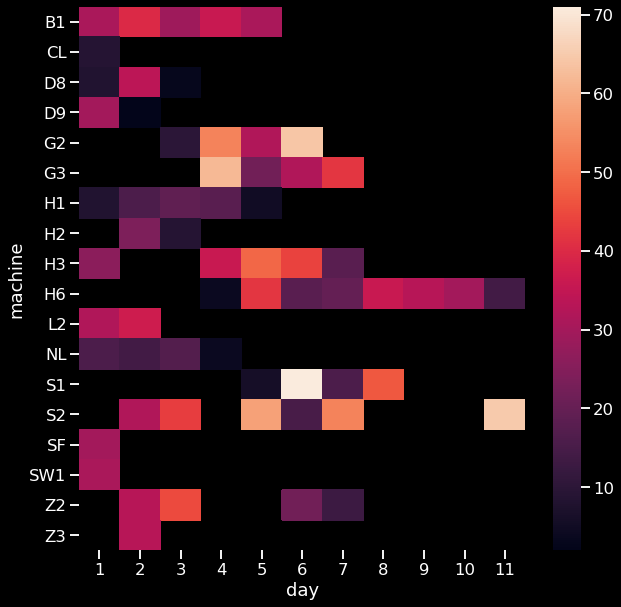

In [31]:
app = Application(factory, BASE_DATE)
app.mainloop()

***
## 描画を省略 
## 時間計測

In [32]:
import time

factory1 = Factory()
factory1.deploy(wk)
#factory1.deploy(sw)
factory1.set_machines(ma)
factory1.planning(pr)

#テスト用 最初の機械は段取り済み
factory1.set_product_to_machine(0)
for machine in factory1.machine_list:
    if machine.status == Mstatus.NOT_SET:
        machine.status = Mstatus.STOP

#スケジュール設定
for worker in factory1.worker_list:
    #Taro
    if worker.name == 'Taro':
        worker.set_schedule(ts)
    #Hanako
    if worker.name == 'Hanako':
        worker.set_schedule(hs)
    #Ichiro
    if worker.name == 'Ichiro':
        worker.set_schedule(i_s)

#SampleWorkers
for worker in factory1.worker_list:
    if worker.name == 'Saburo':
        worker.set_schedule(ss)
    if worker.name == 'Makoto':
        worker.set_schedule(ss)
        
#担当機械登録
taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']
for worker in factory1.worker_list:
    #Tato
    if worker.name == "Taro":
        worker.set_charge_list(taro_charge_list, factory1.machine_list)
    #Hanako
    if worker.name == "Hanako":
        worker.set_charge_list(hanako_charge_list, factory1.machine_list)
    #Ichiro
    if worker.name == "Ichiro":
        worker.set_charge_list(ichiro_charge_list, factory1.machine_list)
        
#SampleWorker
for worker in factory1.worker_list:
    #Saburo
    if worker.name == "Saburo":
        worker.set_charge_list(machines, factory1.machine_list)
    #Makoto
    if worker.name == "Makoto":
        worker.set_charge_list(machines, factory1.machine_list)

#H3故障        
h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]
for machine in factory1.machine_list:
    if machine.machine_name == 'H3':
        for t in h3_trouble_schedule:
            machine.set_trouble_schedule(t[0],t[1])
        
start_time = time.time()
end_time = time.time()

while True:
    factory1.step(60, continue_set_up) #stepTime
    p = []
    for product in factory1.product_list:
        if product.raw_process:
            p.append(product)
    for machine in factory1.machine_list:
        if machine.status != Mstatus.EMPUTY:
            p.append(machine)
    #for worker in factory1.worker_list:
    #    if worker.status != Wstatus.WAIT:
    #        p.append(worker)
    #    if worker.action_list:
    #        p.append(worker)
    if not p:
        end_time = time.time()
        break
        
print(f'工場稼働時間{factory1.time}')
print(f'計算時間 : {end_time - start_time}')

plan = defaultdict(list)
for product in factory1.product_list:
    for fin in product.finished_process:
        plan[fin[0][0]].append([product.product,fin])
        
#print(plan)
print('\n')
print('*'*10, '生産工程', '*'*10)
print(f'計画開始日:{BASE_DATE.date()}')
print
for k, v in plan.items():
    print('\n')
    print('*'*20)
    print(f'機械:{k}')
    v = sorted(v, key=lambda x:x[1][1])
    for process in v:
        print(f'製品:{process[0]}')
        #print(f'開始:{sec_to_timedelta_9h(process[1][1]).days+1}日目')
        print(f'開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(process[1][1]).days).date()} ({sec_to_timedelta_9h(process[1][1]).days+1}日目)')
        #print(f'終了:{sec_to_timedelta_9h(process[1][2]).days+1}日目')
        print(f'終了:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(process[1][2]).days).date()} ({sec_to_timedelta_9h(process[1][2]).days+1}日目)')
    print('*'*20)

工場稼働時間376560
計算時間 : 1.9960806369781494


********** 生産工程 **********
計画開始日:2021-01-25


********************
機械:NL
製品:P1
開始:2021-01-25 (1日目)
終了:2021-01-25 (1日目)
製品:P2
開始:2021-01-25 (1日目)
終了:2021-01-26 (2日目)
製品:P8
開始:2021-01-26 (2日目)
終了:2021-01-27 (3日目)
製品:P10
開始:2021-01-27 (3日目)
終了:2021-01-28 (4日目)
********************


********************
機械:H3
製品:P9
開始:2021-01-25 (1日目)
終了:2021-01-28 (4日目)
製品:P1
開始:2021-01-28 (4日目)
終了:2021-01-29 (5日目)
製品:P8
開始:2021-01-29 (5日目)
終了:2021-02-02 (7日目)
********************


********************
機械:S1
製品:P1
開始:2021-01-29 (5日目)
終了:2021-02-01 (6日目)
製品:P7
開始:2021-02-01 (6日目)
終了:2021-02-02 (7日目)
製品:P8
開始:2021-02-02 (7日目)
終了:2021-02-03 (8日目)
********************


********************
機械:B1
製品:P7
開始:2021-01-25 (1日目)
終了:2021-01-25 (1日目)
製品:P2
開始:2021-01-26 (2日目)
終了:2021-01-27 (3日目)
製品:P10
開始:2021-01-28 (4日目)
終了:2021-02-01 (6日目)
********************


********************
機械:G2
製品:P2
開始:2021-01-27 (3日目)
終了:2021-01-28 (4日目)
製品:P7
開始:2021-01-29 (5日目)
終了:2021-02-01 

In [33]:
print('*'*10, '工期', '*'*10)
print(f'計画開始日:{BASE_DATE.date()}')
for product in factory1.product_list:
    start_time = []
    end_time = []
    for process in product.finished_process:
        start_time.append(process[1])
        end_time.append(process[2])
    print('\n')
    print('*'*20)
    print(f'製品:{product.product}')
    print(f'加工開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(start_time[0]).days).date()} ({sec_to_timedelta_9h(start_time[0]).days+1}日目)')
    #print(f'加工開始:{sec_to_timedelta_9h(start_time[0]).days+1}日目')
    print(f'加工開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(end_time[-1]).days).date()} ({sec_to_timedelta_9h(end_time[-1]).days+1}日目)')
    #print(f'加工終了:{sec_to_timedelta_9h(end_time[-1]).days+1}日目')
    print('*'*20)

********** 工期 **********
計画開始日:2021-01-25


********************
製品:P1
加工開始:2021-01-25 (1日目)
加工開始:2021-02-01 (6日目)
********************


********************
製品:P2
加工開始:2021-01-25 (1日目)
加工開始:2021-02-02 (7日目)
********************


********************
製品:P3
加工開始:2021-01-25 (1日目)
加工開始:2021-01-29 (5日目)
********************


********************
製品:P4
加工開始:2021-01-25 (1日目)
加工開始:2021-01-27 (3日目)
********************


********************
製品:P5
加工開始:2021-01-25 (1日目)
加工開始:2021-01-27 (3日目)
********************


********************
製品:P6
加工開始:2021-01-25 (1日目)
加工開始:2021-01-27 (3日目)
********************


********************
製品:P7
加工開始:2021-01-25 (1日目)
加工開始:2021-02-02 (7日目)
********************


********************
製品:P8
加工開始:2021-01-26 (2日目)
加工開始:2021-02-03 (8日目)
********************


********************
製品:P9
加工開始:2021-01-25 (1日目)
加工開始:2021-02-01 (6日目)
********************


********************
製品:P10
加工開始:2021-01-27 (3日目)
加工開始:2021-02-09 (12日目)
********************


In [34]:
app = Application(factory1, BASE_DATE)
app.mainloop()

***
## 順番を逆にしてみる

In [35]:
for product in products:
    print(product)

('P1', 20, 'NL', 10, 5, 1, 'H3', 10, 1, 1, 'S1', 2, 1, 1)
('P2', 30, 'NL', 10, 5, 1, 'B1', 5, 1, 1, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'H6', 10, 1, 1, 'S2', 2, 1, 1)
('P3', 20, 'CL', 15, 5, 1, 'D8', 15, 1, 1, 'S2', 1, 1, 1, 'Z2', 1, 1, 1)
('P4', 15, 'SW1', 3, 1, 1, 'L2', 10, 1, 1, 'H2', 5, 1, 1)
('P5', 15, 'D9', 10, 1, 1, 'S2', 1, 1, 1, 'Z2', 1, 1, 1)
('P6', 15, 'SF', 5, 1, 1, 'L2', 1, 1, 1, 'Z3', 1, 1, 1)
('P7', 15, 'B1', 5, 1, 1, 'H1', 20, 1, 2, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'S1', 2, 1, 1, 'Z2', 1, 1, 1)
('P8', 30, 'NL', 10, 5, 1, 'H3', 10, 1, 1, 'S1', 2, 1, 1)
('P9', 30, 'H3', 15, 1, 1, 'S2', 1, 1, 1)
('P10', 30, 'NL', 15, 5, 1, 'B1', 5, 1, 1, 'G2', 0.1, 1, 1, 'G3', 0.1, 1, 1, 'H6', 20, 1, 2, 'S2', 1, 1, 1)


In [36]:
new_list = []
for row in products:
    new_list.insert(0,row)

In [37]:
products2 = new_list
pr2 = pd.DataFrame(products2, columns=(
    'product', 'lot', 
    'process-1', 'time-1', 'auto-1', 'repeat-1', 
    'process-2', 'time-2', 'auto-2', 'repeat-2', 
    'process-3', 'time-3', 'auto-3', 'repeat-3',
    'process-4', 'time-4', 'auto-4', 'repeat-4', 
    'process-5', 'time-5', 'auto-5', 'repeat-5',
    'process-6', 'time-6', 'auto-6', 'repeat-6'))
pr2

,product,lot,process-1,time-1,auto-1,repeat-1,process-2,time-2,auto-2,repeat-2,...,auto-4,repeat-4,process-5,time-5,auto-5,repeat-5,process-6,time-6,auto-6,repeat-6
0,P10,30,NL,15,5,1,B1,5,1,1,...,1.0,1.0,H6,20.0,1.0,2.0,S2,1.0,1.0,1.0
1,P9,30,H3,15,1,1,S2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
2,P8,30,NL,10,5,1,H3,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
3,P7,15,B1,5,1,1,H1,20,1,2,...,1.0,1.0,S1,2.0,1.0,1.0,Z2,1.0,1.0,1.0
4,P6,15,SF,5,1,1,L2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
5,P5,15,D9,10,1,1,S2,1,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
6,P4,15,SW1,3,1,1,L2,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN
7,P3,20,CL,15,5,1,D8,15,1,1,...,1.0,1.0,None,NaN,NaN,NaN,None,NaN,NaN,NaN
8,P2,30,NL,10,5,1,B1,5,1,1,...,1.0,1.0,H6,10.0,1.0,1.0,S2,2.0,1.0,1.0
9,P1,20,NL,10,5,1,H3,10,1,1,...,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,NaN


In [38]:
import time

factory2 = Factory()
factory2.deploy(wk)
factory2.set_machines(ma)
factory2.planning(pr2)

#テスト用 最初の機械は段取り済み
factory2.set_product_to_machine(0)
for machine in factory2.machine_list:
    if machine.status == Mstatus.NOT_SET:
        machine.status = Mstatus.STOP

#スケジュール設定
for worker in factory2.worker_list:
    #Taro
    if worker.name == 'Taro':
        worker.set_schedule(ts)
    #Hanako
    if worker.name == 'Hanako':
        worker.set_schedule(hs)
    #Ichiro
    if worker.name == 'Ichiro':
        worker.set_schedule(i_s)

#担当機械登録
taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']
for worker in factory2.worker_list:
    #Tato
    if worker.name == "Taro":
        worker.set_charge_list(taro_charge_list, factory2.machine_list)
    #Hanako
    if worker.name == "Hanako":
        worker.set_charge_list(hanako_charge_list, factory2.machine_list)
    #Ichiro
    if worker.name == "Ichiro":
        worker.set_charge_list(ichiro_charge_list, factory2.machine_list)

#H3故障
h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]
for machine in factory2.machine_list:
    if machine.machine_name == 'H3':
        for t in h3_trouble_schedule:
            machine.set_trouble_schedule(t[0],t[1])
        
start_time = time.time()
end_time = time.time()

while True:
    factory2.step(60, continue_set_up) #stepTime
    p = []
    for product in factory2.product_list:
        if product.raw_process:
            p.append(product)
    for machine in factory2.machine_list:
        if machine.status != Mstatus.EMPUTY:
            p.append(machine)
    #for worker in factory2.worker_list:
    #    if worker.status != Wstatus.WAIT:
    #        p.append(worker)
    #    if worker.action_list:
    #        p.append(worker)
    if not p:
        end_time = time.time()
        break
        
print(f'工場稼働時間{factory2.time}')
print(f'計算時間 : {end_time - start_time}')

plan = defaultdict(list)
for product in factory2.product_list:
    for fin in product.finished_process:
        plan[fin[0][0]].append([product.product,fin])
        
#print(plan)
print('\n')
print('*'*10, '生産工程', '*'*10)
print(f'計画開始日:{BASE_DATE.date()}')
print
for k, v in plan.items():
    print('\n')
    print('*'*20)
    print(f'機械:{k}')
    v = sorted(v, key=lambda x:x[1][1])
    for process in v:
        print(f'製品:{process[0]}')
        #print(f'開始:{sec_to_timedelta_9h(process[1][1]).days+1}日目')
        print(f'開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(process[1][1]).days).date()} ({sec_to_timedelta_9h(process[1][1]).days+1}日目)')
        #print(f'終了:{sec_to_timedelta_9h(process[1][2]).days+1}日目')
        print(f'終了:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(process[1][2]).days).date()} ({sec_to_timedelta_9h(process[1][2]).days+1}日目)')
    print('*'*20)

工場稼働時間333120
計算時間 : 1.942657470703125


********** 生産工程 **********
計画開始日:2021-01-25


********************
機械:NL
製品:P10
開始:2021-01-25 (1日目)
終了:2021-01-26 (2日目)
製品:P8
開始:2021-01-26 (2日目)
終了:2021-01-26 (2日目)
製品:P2
開始:2021-01-26 (2日目)
終了:2021-01-27 (3日目)
製品:P1
開始:2021-01-27 (3日目)
終了:2021-01-28 (4日目)
********************


********************
機械:B1
製品:P7
開始:2021-01-25 (1日目)
終了:2021-01-25 (1日目)
製品:P10
開始:2021-01-26 (2日目)
終了:2021-01-27 (3日目)
製品:P2
開始:2021-01-27 (3日目)
終了:2021-01-28 (4日目)
********************


********************
機械:G2
製品:P10
開始:2021-01-27 (3日目)
終了:2021-01-27 (3日目)
製品:P2
開始:2021-01-28 (4日目)
終了:2021-01-29 (5日目)
製品:P7
開始:2021-01-29 (5日目)
終了:2021-02-01 (6日目)
********************


********************
機械:G3
製品:P10
開始:2021-01-27 (3日目)
終了:2021-01-28 (4日目)
製品:P2
開始:2021-01-29 (5日目)
終了:2021-02-01 (6日目)
製品:P7
開始:2021-02-01 (6日目)
終了:2021-02-01 (6日目)
********************


********************
機械:H6
製品:P10
開始:2021-01-28 (4日目)
終了:2021-02-03 (8日目)
製品:P2
開始:2021-02-03 (8日目)
終了:2021-02-0

In [39]:
print('*'*10, '工期', '*'*10)
print(f'計画開始日:{BASE_DATE.date()}')
for product in factory2.product_list:
    start_time = []
    end_time = []
    for process in product.finished_process:
        start_time.append(process[1])
        end_time.append(process[2])
    print('\n')
    print('*'*20)
    print(f'製品:{product.product}')
    print(f'加工開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(start_time[0]).days).date()} ({sec_to_timedelta_9h(start_time[0]).days+1}日目)')
    #print(f'加工開始:{sec_to_timedelta_9h(start_time[0]).days+1}日目')
    print(f'加工開始:{return_biz_day(BASE_DATE, sec_to_timedelta_9h(end_time[-1]).days).date()} ({sec_to_timedelta_9h(end_time[-1]).days+1}日目)')
    #print(f'加工終了:{sec_to_timedelta_9h(end_time[-1]).days+1}日目')
    print('*'*20)

********** 工期 **********
計画開始日:2021-01-25


********************
製品:P10
加工開始:2021-01-25 (1日目)
加工開始:2021-02-05 (10日目)
********************


********************
製品:P9
加工開始:2021-01-25 (1日目)
加工開始:2021-01-29 (5日目)
********************


********************
製品:P8
加工開始:2021-01-26 (2日目)
加工開始:2021-02-02 (7日目)
********************


********************
製品:P7
加工開始:2021-01-25 (1日目)
加工開始:2021-02-03 (8日目)
********************


********************
製品:P6
加工開始:2021-01-25 (1日目)
加工開始:2021-01-27 (3日目)
********************


********************
製品:P5
加工開始:2021-01-25 (1日目)
加工開始:2021-01-26 (2日目)
********************


********************
製品:P4
加工開始:2021-01-25 (1日目)
加工開始:2021-01-27 (3日目)
********************


********************
製品:P3
加工開始:2021-01-25 (1日目)
加工開始:2021-01-28 (4日目)
********************


********************
製品:P2
加工開始:2021-01-26 (2日目)
加工開始:2021-02-08 (11日目)
********************


********************
製品:P1
加工開始:2021-01-27 (3日目)
加工開始:2021-02-04 (9日目)
********************


In [40]:
limit_time = 9*60*60 * 15
factory_objects = [factory1, factory2]
product_list = ['P1 -> P10', 'P10 -> P1']

n = 1
for factory in factory_objects:
    print(product_list[n-1])
    print(f'{factory.time}秒')
    print(f'{sec_to_timedelta_9h(factory.time)}')
    print('\n')
    n += 1

P1 -> P10
376560秒
11 days, 5:36:00


P10 -> P1
333120秒
10 days, 2:32:00




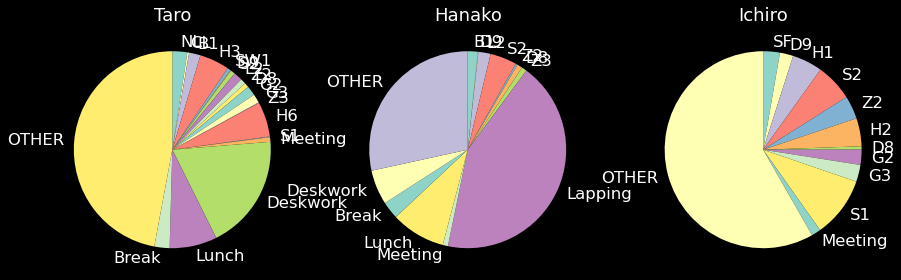

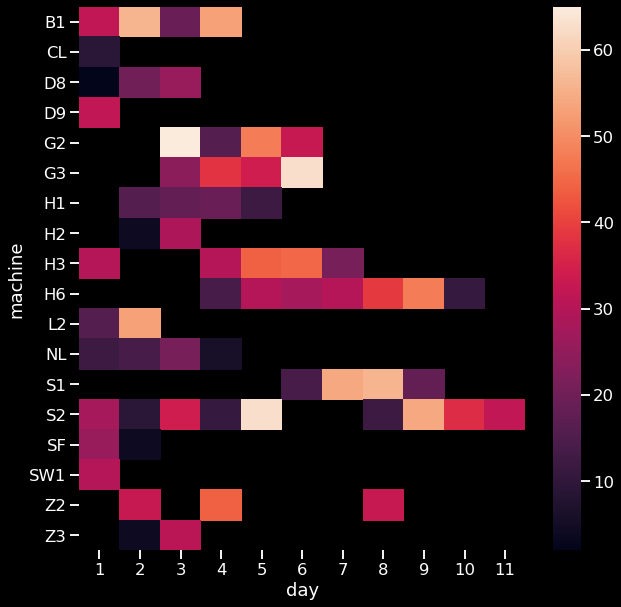

In [41]:
app = Application(factory2, BASE_DATE)
app.mainloop()

***
## ランダムに並び替えたデータを10個作成

In [42]:
import time
import random

In [43]:
#ラダンダムに並び替え
random.seed(1)

s_factory = None
random_factories = []
random_df_list = []
factory_time = 1000*9*60*60

rec_start = time.time()
rec_end = time.time()

for _ in range(10):
    random_products_list = random.sample(products, len(products))

    random_products = pd.DataFrame(random_products_list, columns=(
        'product', 'lot', 
        'process-1', 'time-1', 'auto-1', 'repeat-1', 
        'process-2', 'time-2', 'auto-2', 'repeat-2', 
        'process-3', 'time-3', 'auto-3', 'repeat-3',
        'process-4', 'time-4', 'auto-4', 'repeat-4', 
        'process-5', 'time-5', 'auto-5', 'repeat-5',
        'process-6', 'time-6', 'auto-6', 'repeat-6'))
    random_df_list.append(random_products)
    
    random_factory = Factory()
    random_factory.deploy(wk)
    random_factory.set_machines(ma)
    random_factory.planning(random_products)
    
    #テスト用 最初の機械は段取り済み
    random_factory.set_product_to_machine(0)
    for machine in random_factory.machine_list:
        if machine.status == Mstatus.NOT_SET:
            machine.status = Mstatus.STOP
    
    #スケジュール設定
    for worker in random_factory.worker_list:
        #Taro
        if worker.name == 'Taro':
            worker.set_schedule(ts)
        #Hanako
        if worker.name == 'Hanako':
            worker.set_schedule(hs)
        #Ichiro
        if worker.name == 'Ichiro':
            worker.set_schedule(i_s)

    #担当機械登録
    taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
    hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
    ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']
    for worker in random_factory.worker_list:
        #Tato
        if worker.name == "Taro":
            worker.set_charge_list(taro_charge_list, random_factory.machine_list)
        #Hanako
        if worker.name == "Hanako":
            worker.set_charge_list(hanako_charge_list, random_factory.machine_list)
        #Ichiro
        if worker.name == "Ichiro":
            worker.set_charge_list(ichiro_charge_list, random_factory.machine_list)

    #H3故障        
    h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]
    for machine in random_factory.machine_list:
        if machine.machine_name == 'H3':
            for t in h3_trouble_schedule:
                machine.set_trouble_schedule(t[0],t[1])

    while True:
        random_factory.step(60, continue_set_up) #stepTime
        p = []
        for product in random_factory.product_list:
            if product.raw_process:
                p.append(product)
        for machine in random_factory.machine_list:
            if machine.status != Mstatus.EMPUTY:
                p.append(machine)
        #for worker in random_factory.worker_list:
        #    if worker.status != Wstatus.WAIT:
        #        p.append(worker)
        #    if worker.action_list:
        #        p.append(worker)
        if not p:
            random_factories.append(random_factory)
            break
            
    if random_factory.time < factory_time:
        factory_time = random_factory.time
        s_factory = random_factory

rec_end = time.time()

print(f'工場稼働時間 : {sec_to_timedelta_9h(s_factory.time)}')
print(f'計算時間 : {rec_end - rec_start}')

工場稼働時間 : 9 days, 5:36:00
計算時間 : 20.35928726196289


In [ ]:
#app = Application(s_factory, BASE_DATE)
#app.mainloop() 

In [44]:
for product in s_factory.product_list:
    print(product.product)

P9
P6
P2
P4
P10
P5
P1
P7
P8
P3


In [45]:
i = 0
for factory in random_factories:
    print(f'({i})稼働時間 : {sec_to_timedelta_9h(factory.time)}')
    i += 1

(0)稼働時間 : 11 days, 4:54:00
(1)稼働時間 : 11 days, 4:54:00
(2)稼働時間 : 11 days, 4:54:00
(3)稼働時間 : 11 days, 4:54:00
(4)稼働時間 : 11 days, 2:55:00
(5)稼働時間 : 10 days, 5:30:00
(6)稼働時間 : 9 days, 5:58:00
(7)稼働時間 : 9 days, 5:36:00
(8)稼働時間 : 11 days, 2:55:00
(9)稼働時間 : 11 days, 4:54:00


In [46]:
for product in random_factories[6].product_list:
    print(product.product)

P10
P1
P8
P2
P6
P4
P5
P3
P9
P7


***
## 最初の計画と、ランダムに並び替えたものの中で一番成績の良かったものを比較

In [47]:
limit_time = 9*60*60 * 15
factory_objects = [factory1, random_factories[7]]

n = 1
for factory in factory_objects:
    print(f'CASE{n}')
    print(f'{factory.time}秒')
    print(f'{sec_to_timedelta_9h(factory.time)}')
    print('\n')
    n += 1

CASE1
376560秒
11 days, 5:36:00


CASE2
311760秒
9 days, 5:36:00




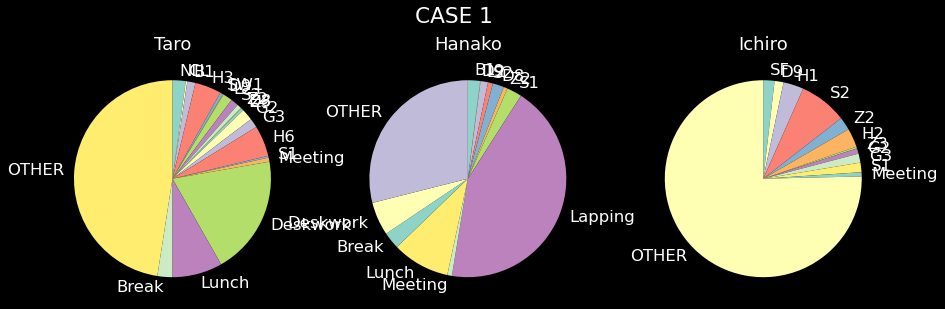

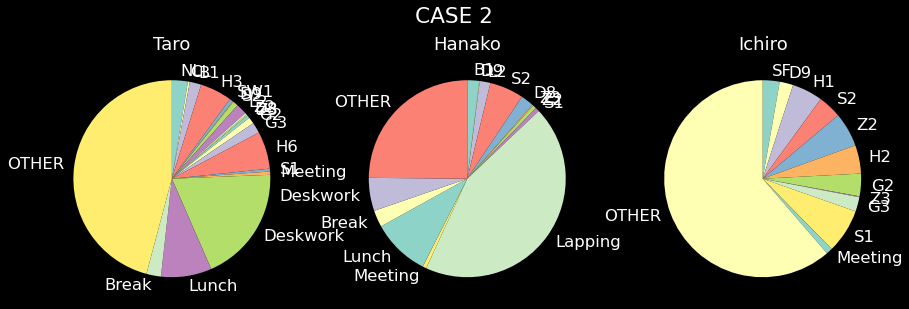

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

n = 1
for factory in factory_objects:
    
    if limit_time > factory.time:
        limit_time = factory.time
        
    dic = defaultdict(list)

    worker_list = copy.deepcopy(factory.worker_list)
    for worker in worker_list:
    #for worker in factory.worker_list:
        for rec in worker.record: #worker.record =[[作業内容, 対象機械, 開始時間, 終了時間], []...]
            if rec[3] < limit_time:
                dic[worker.name].append(rec)

    lst=[]
    dd={}
    for k, v in dic.items():
        d = defaultdict(list)
        for rec in v:
            d[rec[0]].append([rec[1], rec[3]-rec[2]])
        dd[k] = d
    for name, rec in dd.items():
        for action, m_t in rec.items():
            ddd = defaultdict(list)
            for raw in m_t:
                ddd[raw[0]].append(raw[1])
            dddd = {}
            for machine, time in ddd.items():
                dddd[machine] = sum(time)
            lst.append([name, action, dddd])

    record_dic = defaultdict(list)
    for raw in lst:
        if raw[1] != 'move':
            record_dic[raw[0]].append([raw[1], raw[2]])

    record_list = []
    for name, l in record_dic.items():
        lst = []
        for raw in l:
            df = pd.DataFrame(raw[1].values(),index=raw[1].keys(),columns=[raw[0]]).T
            lst.append(df)
        record_list.append([name, lst])

    record = []
    for name, df_list in record_list:
        df_concat = pd.concat(df_list)
        record.append([name, df_concat])

    record_sum = []
    w = []
    for rec in record:
        w.append(rec[0])
    for worker in factory.worker_list:
        if worker.name not in w:
            record_sum.append(
                [worker.name, pd.Series((0,), index=('None',))]
                )
    for rec in record:
        record_sum.append([rec[0], rec[1].sum()])

    record_total = []
    for rec_sum in record_sum:
        for worker in factory.worker_list:
            if worker.name == rec_sum[0]:
                df_other = pd.Series(
                    [
                        worker.return_attendance_time(0, limit_time, factory.time) - rec_sum[1].sum()
                        ], index=['OTHER'])
                d = rec_sum[1].append([df_other])
                record_total.append([rec_sum[0], d])

    if record_total:
        plt.rcParams['figure.figsize'] = (15.0, 5.0)
        sns.set_context('talk')
        plt.style.use('dark_background')

        fig, ax = plt.subplots(1, len(record_total))
        fig.suptitle(f'CASE {n}')

        i=0
        for rec in record_total:
            try:
                if rec:
                    ax[i].set_title(rec[0])
                    ax[i].pie(
                        rec[1], labels=rec[1].index, startangle=90, 
                        counterclock=False, normalize=True)
                    #ax[i].legend();
                    i += 1
            except:
                pass
        """
        i=0
        for rec in record_total:
            ax[i].set_title(rec[0])
            ax[i].pie(
                rec[1], labels=rec[1].index, startangle=90, counterclock=False)
            #ax[i].legend(bbox_to_anchor=(0, 1));
            i += 1
        """
        fig.savefig(f"workers_case{n}.png")
    n += 1

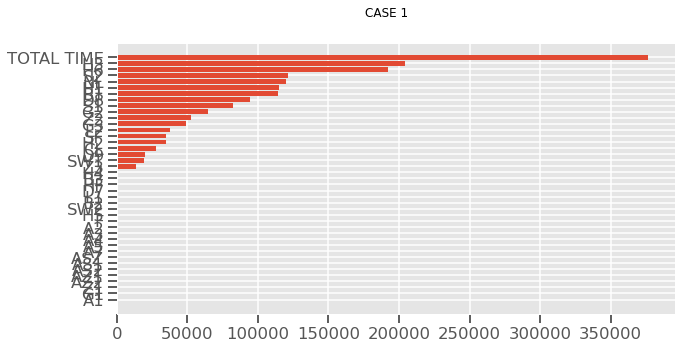

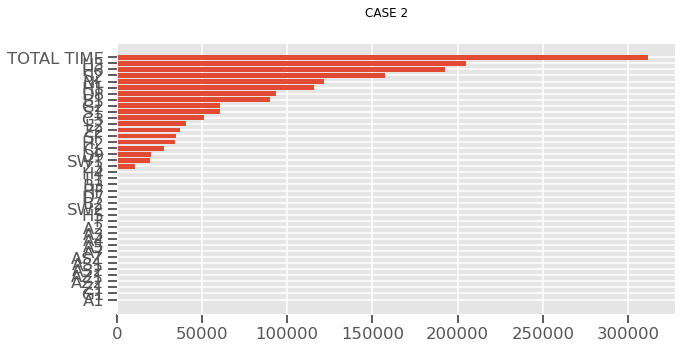

In [49]:
limit_time = 9*60*60 * 15

n = 1
for factory in factory_objects:

    if limit_time > factory.time:
        limit_time = factory.time

    lst = []
    for product in factory.product_list:
        for fin in product.finished_process:
            if fin[1] <= limit_time:
                if fin[2] > limit_time:
                    fin[2] = limit_time
                lst.append([product.product, fin[0][0], fin[2]-fin[1]])

    machine_run_dic = defaultdict(list)
    for l in lst:
        machine_run_dic[l[1]].append(l[2])
    machine_run_sum = {}
    machine_run_sum['TOTAL TIME'] = limit_time
    for machine in factory.machine_list:
        machine_run_sum[machine.machine_name] = 0
    for k, v in machine_run_dic.items():
        machine_run_sum[k] = sum(v)
    df = pd.DataFrame(
        machine_run_sum.values(), 
        index=machine_run_sum.keys(), columns=['runtime'])
    sdf = df.sort_values(by='runtime',ascending=True)

    plt.rcParams['figure.figsize'] = (10.0, 5.0)
    sns.set_context('talk')
    plt.style.use('ggplot')

    fig, ax = plt.subplots(1, 1)
    fig.suptitle(f'CASE {n}', color='black')
    ax.barh(sdf.index, sdf['runtime'], height=0.8);
    
    fig.savefig(f"machines_case{n}.png")
    n += 1

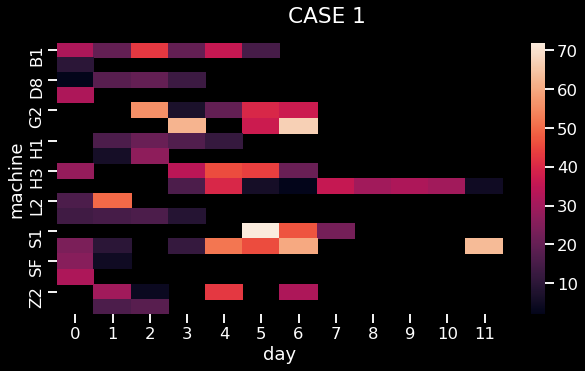

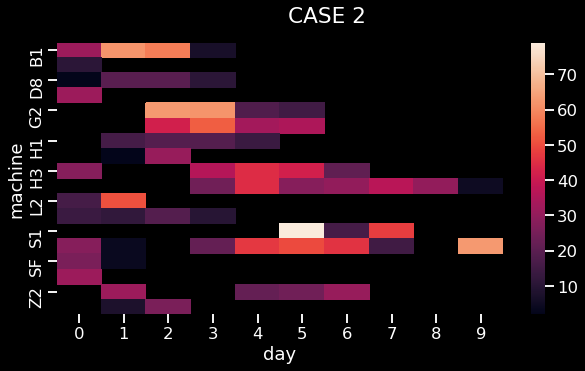

In [51]:
n = 1
for factory in factory_objects:
    lst = []
    machines = []
    for machine in factory.machine_list:
        machines.append(machine.machine_name)
    for worker in factory.worker_list:
        for rec in worker.record:
            if rec[1] in machines:
                lst.append(rec)

    df = pd.DataFrame(lst)
    df2 = df[[1,2]].copy()

    def get_day(time):
        return sec_to_timedelta_9h(time).days

    df2['day'] = df2[2].apply(get_day)
    df2 = df2.rename(columns={1:'machine'})
    p_df = df2.pivot_table(values=2, index='machine', columns='day', aggfunc='count')

    plt.rcParams['figure.figsize'] = (10.0, 5.0)
    sns.set_context('talk')
    plt.style.use('dark_background')

    fig, ax = plt.subplots(1,1)
    fig.suptitle(f'CASE {n}')
    
    sns.heatmap(p_df);
    fig.savefig(f"heatmap_case{n}.png")
    n += 1

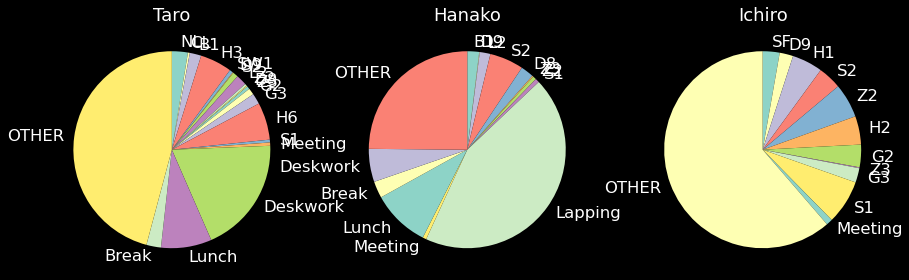

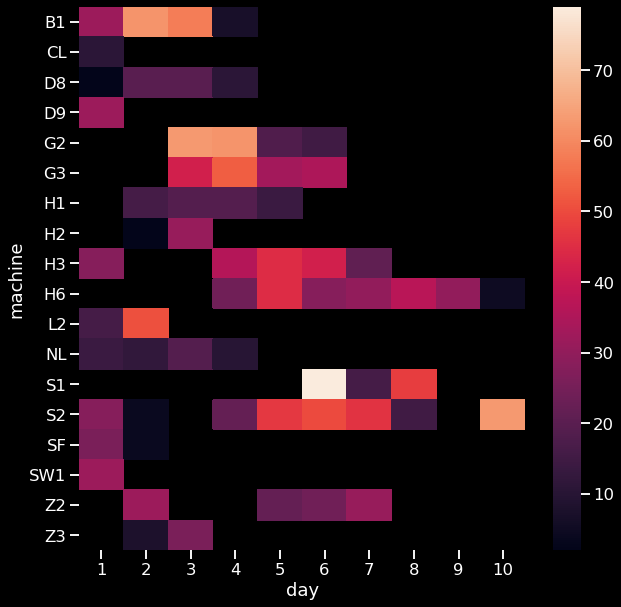

In [52]:
app = Application(random_factories[7], BASE_DATE)
app.mainloop()

***
## 成績が良かった生産リストでシミュレート

In [ ]:
#factory初期化
r_factory = Factory()

In [ ]:
random_df_list[7]

In [ ]:
#作業者登録
r_factory.deploy(wk)
#r_factory.deploy(sw)

r_factory.set_machines(ma) #機械登録
r_factory.planning(random_df_list[7]) #生産計画登録

In [ ]:
#スケジュール設定
for worker in r_factory.worker_list:
    #Taro
    if worker.name == 'Taro':
        worker.set_schedule(ts)
    #Hanako
    if worker.name == 'Hanako':
        worker.set_schedule(hs)
    #Ichiro
    if worker.name == 'Ichiro':
        worker.set_schedule(i_s)

#SampleWorkers
for worker in r_factory.worker_list:
    if worker.name == 'Saburo':
        worker.set_schedule(ss)
    if worker.name == 'Makoto':
        worker.set_schedule(ss)
        
#担当機械登録
taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']
for worker in r_factory.worker_list:
    #Tato
    if worker.name == "Taro":
        worker.set_charge_list(taro_charge_list, r_factory.machine_list)
    #Hanako
    if worker.name == "Hanako":
        worker.set_charge_list(hanako_charge_list, r_factory.machine_list)
    #Ichiro
    if worker.name == "Ichiro":
        worker.set_charge_list(ichiro_charge_list, r_factory.machine_list)
        
#SampleWorker
for worker in r_factory.worker_list:
    #Saburo
    if worker.name == "Saburo":
        worker.set_charge_list(machines, r_factory.machine_list)
    #Makoto
    if worker.name == "Makoto":
        worker.set_charge_list(machines, r_factory.machine_list)

#H3故障        
h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]
for machine in r_factory.machine_list:
    if machine.machine_name == 'H3':
        for t in h3_trouble_schedule:
            machine.set_trouble_schedule(t[0],t[1])

In [ ]:
#テスト用 最初の機械は段取り済み
r_factory.set_product_to_machine(0)
for machine in r_factory.machine_list:
    if machine.status == Mstatus.NOT_SET:
        machine.status = Mstatus.STOP

In [ ]:
app = Application(r_factory, BASE_DATE)
app.mainloop()

In [ ]:
#print(f'工場稼働時間{r_factory.time}')
#print(f'工場稼働時間 : {sec_to_timedelta_9h(r_factory.time)}')

***
## 人数を増やしてシミュレート

In [53]:
#factory初期化
w5_factory = Factory()

In [54]:
#作業者登録
w5_factory.deploy(sw)

w5_factory.set_machines(ma) #機械登録
w5_factory.planning(random_df_list[7]) #生産計画登録

In [55]:
#スケジュール設定
for worker in w5_factory.worker_list:
    #Taro
    if worker.name == 'Taro':
        worker.set_schedule(ts)
    #Hanako
    if worker.name == 'Hanako':
        worker.set_schedule(hs)
    #Ichiro
    if worker.name == 'Ichiro':
        worker.set_schedule(i_s)

#SampleWorkers
for worker in w5_factory.worker_list:
    if worker.name == 'Saburo':
        worker.set_schedule(ss)
    if worker.name == 'Makoto':
        worker.set_schedule(ss)
        
#担当機械登録
taro_charge_list = ['NL', 'CL', 'L1', 'L2', 'B1', 'B2', 'B3', 'H3', 'H4', 'H5', 'F', 'H6', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3', 'SW1','SW2']
hanako_charge_list = ['L2', 'B1', 'B3', 'HF', 'D7', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z2', 'Z3']
ichiro_charge_list = ['HF', 'D7', 'H1', 'SF', 'H2', 'D8', 'D9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'ASZ', 'AS1', 'AS2', 'AZ1', 'AZ2', 'S1', 'S2', 'Z1', 'Z2', 'Z3', 'G1', 'G2', 'G3']
for worker in w5_factory.worker_list:
    #Tato
    if worker.name == "Taro":
        worker.set_charge_list(taro_charge_list, w5_factory.machine_list)
    #Hanako
    if worker.name == "Hanako":
        worker.set_charge_list(hanako_charge_list, w5_factory.machine_list)
    #Ichiro
    if worker.name == "Ichiro":
        worker.set_charge_list(ichiro_charge_list, w5_factory.machine_list)
        
#SampleWorker
for worker in w5_factory.worker_list:
    #Saburo
    if worker.name == "Saburo":
        worker.set_charge_list(machines, w5_factory.machine_list)
    #Makoto
    if worker.name == "Makoto":
        worker.set_charge_list(machines, w5_factory.machine_list)

#H3故障        
h3_trouble_schedule = [[1*9*60*60, 3*9*60*60], [15*9*60*60, 16*9*60*60]]
for machine in w5_factory.machine_list:
    if machine.machine_name == 'H3':
        for t in h3_trouble_schedule:
            machine.set_trouble_schedule(t[0],t[1])

In [56]:
#テスト用 最初の機械は段取り済み
w5_factory.set_product_to_machine(0)
for machine in w5_factory.machine_list:
    if machine.status == Mstatus.NOT_SET:
        machine.status = Mstatus.STOP

In [ ]:
app = Application(w5_factory, BASE_DATE)
app.mainloop()

In [ ]:
print(f'工場稼働時間{w5_factory.time}')
print(f'工場稼働時間 : {sec_to_timedelta_9h(w5_factory.time)}')